# Import packages and load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
from datasets import load_dataset
from collections import Counter

In [5]:
# load dataset and convert to dataframe
ds = load_dataset("Nooha/cc_fraud_detection_dataset")
ds.set_format(type='pandas')
df = ds['train'][:]

In [6]:
df.head()

,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,dob,acct_num,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant
0,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,c036244703adb9d5392f4027d9d4b38d,2021-07-31,02:30:01,1627678801,grocery_pos,337.54,1,fraud_Kovacek
1,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,42f000b0b3b0ef534e5b8ef9ec1db13a,2021-08-01,22:37:41,1627837661,personal_care,21.13,1,fraud_Bradtke
2,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,543037b1baf088961e58d00b705f4bcc,2021-08-01,23:02:09,1627839129,personal_care,22.61,1,fraud_Kozey-Kuhlman
3,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,00a4e08643edebf9277c2967676f6a26,2021-08-01,22:27:24,1627837044,health_fitness,17.32,1,fraud_Hills
4,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,492c4412815306718f686fc5b459a285,2021-12-02,02:28:51,1638392331,misc_pos,75.82,0,fraud_Kemmer-Buckridge


# Feature Engineering

In [7]:
# drop irrelevant columns
columns_to_drop = ['ssn', 'first', 'last', 'trans_num', 'acct_num']
df = df.drop(columns=columns_to_drop)

# convert date to datetime object
df['trans_date'] = pd.to_datetime(df['trans_date'], errors = 'coerce')

# create columns for year, month, date and (month year)
df['trans_date_year'] = df['trans_date'].dt.year
df['trans_date_month'] = df['trans_date'].dt.month
df['trans_date_day'] = df['trans_date'].dt.day
df['trans_ym'] = df['trans_date'].dt.to_period('M')

# create column for hour of transaction
df['trans_time_hr'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S').dt.hour

# convert DOB to datetime object
df['dob'] = pd.to_datetime(df['dob'])

# append state name to city to avoid mix-ups
df['city'] = df['city'] + ', ' + df['state']

In [8]:
# calculate customer age
def calc_age(data):
    est = data['trans_date'].year - data['dob'].year
    if (data['trans_date'].month < data['dob'].month) or ((data['trans_date'].month == data['dob'].month) and (data['trans_date'].day < data['dob'].day)):
        return est - 1
    else:
        return est
    
df['age'] = df.apply(lambda x: calc_age(x), axis = 1)

In [9]:
# create age brackets
def age_range(data):
    if data['age'] < 21:
        return 'Under 21' 
    elif data['age'] // 10 == 2:
        return '21-29' 
    elif data['age'] // 10 == 3:
        return '30-39' 
    elif data['age'] // 10 == 4:
        return '40-49' 
    elif data['age'] // 10 == 5:
        return '50-59' 
    elif data['age'] // 10 == 6:
        return '60-69' 
    else:
        return '70 and above'

df['age_range'] = df.apply(lambda x: age_range(x), axis = 1)

In [10]:
# NOTE: merchants that have at least 1 associated fraudulent transaction will be known as 'fraud merchants'/'fraudulent merchants'

# separate fraudulent and non-fraudulent transactions into 2 datasets
fraud_trans_df = df.loc[df['is_fraud'] == 1]
not_fraud_trans_df = df.loc[df['is_fraud'] == 0]

# create dataset for all transactions by fraudulent merchants
fraud_merchants = fraud_trans_df['merchant'].unique()
fraud_merchants_df = df.loc[df['merchant'].isin(fraud_merchants)]

# create dataset for all transactions by non-fraudulent merchants
not_fraud_merchants = list(set(df['merchant']) - set(fraud_merchants))
not_fraud_merchants_df = df.loc[df['merchant'].isin(not_fraud_merchants)]

In [53]:
# obtain first and last fraudulent transaction of all fradulent merchants
first_last_fraud = fraud_trans_df.groupby('merchant')['trans_date'].agg(['min', 'max']).reset_index()
# obtain first and last transaction of all merchants
first_last_trans = df.groupby('merchant')['trans_date'].agg(['min', 'max']).reset_index()
# combine to get first and last fraud and regular transaction for all fraudulent merchants
fraud_merchant_enter_exit = pd.merge(first_last_fraud, first_last_trans, on = 'merchant', how = 'left', suffixes = ('_fraud', '_total'))

# warmup = no. of days between first transaction and first fraud
# create column for warmup period
fraud_merchant_enter_exit['warmup_period'] = (fraud_merchant_enter_exit['min_fraud'] - fraud_merchant_enter_exit['min_total']).dt.day
# create bins for warmup periods
fraud_merchant_enter_exit['warmup_period_grp'] = ['0 days' if x == 0 else '1 - 30 days' if x >= 1 and x <= 30 else '> 30 days' for x in fraud_merchant_enter_exit['warmup_period']]

# cooldown = no. of days between last fraud and last transaction
# create column for cooldown period
fraud_merchant_enter_exit['cooldown_period'] = (fraud_merchant_enter_exit['max_total'] - fraud_merchant_enter_exit['max_fraud']).dt.days
# create bins for cooldown periods
fraud_merchant_enter_exit['cooldown_period_grp'] = ['0 days' if x == 0 else '1 - 30 days' if x >= 1 and x <= 30 else '> 30 days' for x in fraud_merchant_enter_exit['cooldown_period']]


# Data cleaning

There are no NA or duplicate rows

In [11]:
df.isna().sum()

cc_num              0
gender              0
city                0
state               0
zip                 0
city_pop            0
job                 0
dob                 0
trans_date          0
trans_time          0
unix_time           0
category            0
amt                 0
is_fraud            0
merchant            0
trans_date_year     0
trans_date_month    0
trans_date_day      0
trans_ym            0
trans_time_hr       0
age                 0
age_range           0
dtype: int64

In [12]:
print(len(df))
print(len(df.drop_duplicates()))

2646694
2646694


In [13]:
df['category'].unique()

array(['grocery_pos', 'personal_care', 'health_fitness', 'misc_pos',
       'gas_transport', 'misc_net', 'grocery_net', 'home', 'shopping_pos',
       'entertainment', 'kids_pets', 'shopping_net', 'food_dining',
       'travel'], dtype=object)

# EDA

### Merchant

Almost all merchants have been involved in fraud at some point

In [14]:
print(f"There are {len(df['merchant'].unique())} unique merchants")
print(f"There are {len(fraud_merchants)} unique merchants involved in fraud")

There are 648 unique merchants
There are 641 unique merchants involved in fraud


Fraudulent merchants are likely to immediately get involved in fraud - 83% of the time, their first transaction is already fraudulent.
Similarly, 68% of them stopped transacting after the last fraud transaction.

This could lead to a hypothesis that some of these merchant accounts were created by fraudsters solely for the purpose of pulling off these frauds.

In [56]:
first_trans = fraud_merchants_df.sort_values('trans_date').groupby('merchant').head(1)
first_trans['is_fraud'].value_counts(normalize = True)

is_fraud
1    0.833073
0    0.166927
Name: proportion, dtype: float64

In [79]:
last_trans = fraud_merchants_df.sort_values('trans_date').groupby('merchant').tail(1)
last_trans['is_fraud'].value_counts(normalize = True)

is_fraud
1    0.684867
0    0.315133
Name: proportion, dtype: float64

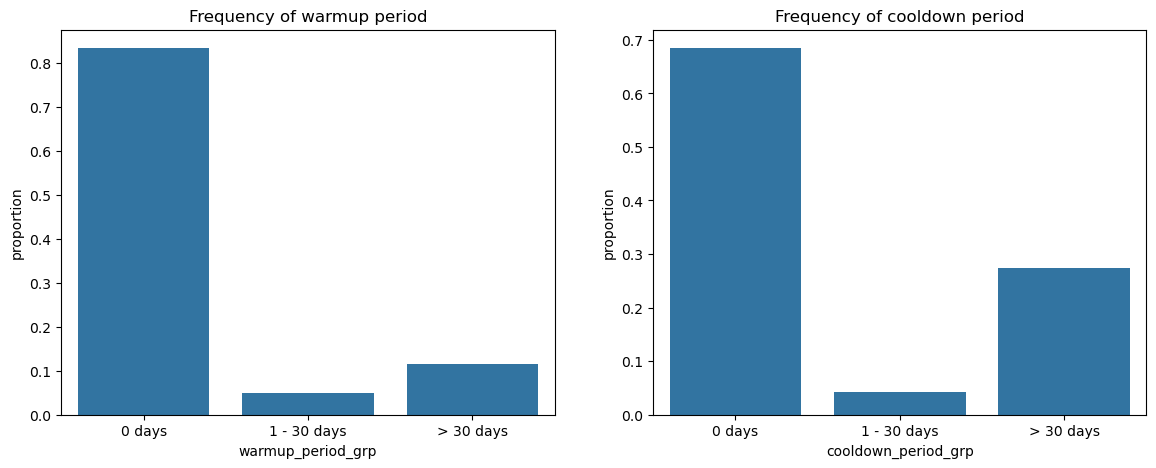

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})
order = ['0 days', '1 - 30 days', '> 30 days']
warmup_period_grps = fraud_merchant_enter_exit['warmup_period_grp'].value_counts(normalize = True).reset_index()
sns.barplot(data = warmup_period_grps, x = 'warmup_period_grp', y = 'proportion', ax = axes[0], order = order)
axes[0].set_title('Frequency of warmup period')
warmup_period_grps = fraud_merchant_enter_exit['cooldown_period_grp'].value_counts(normalize = True).reset_index()
sns.barplot(data = warmup_period_grps, x = 'cooldown_period_grp', y = 'proportion', ax = axes[1], order = order)
axes[1].set_title('Frequency of cooldown period')
plt.show()

Not sure if we need to account for the fact that 1st transaction in dataset != 1st ever transaction? (similarly last transaction in dataset != last ever transaction). Created a version below that excludes any merchant where their 1st ever transaction is in the 1st week of the dataset or if their last ever transaction is in the last week of the dataset

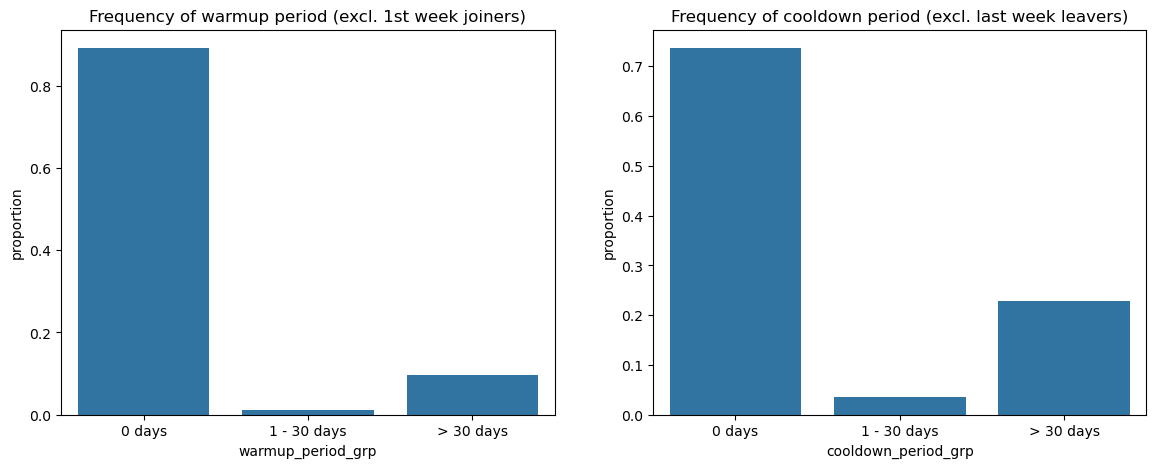

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})
order = ['0 days', '1 - 30 days', '> 30 days']
warmup_period_grps = fraud_merchant_enter_exit.loc[fraud_merchant_enter_exit['min_total'] > '2021-01-07', 'warmup_period_grp'].value_counts(normalize = True).reset_index()
sns.barplot(data = warmup_period_grps, x = 'warmup_period_grp', y = 'proportion', ax = axes[0], order = order)
axes[0].set_title('Frequency of warmup period (excl. 1st week joiners)')
cooldown_period_grps = fraud_merchant_enter_exit.loc[fraud_merchant_enter_exit['max_total'] < '2023-12-24', 'cooldown_period_grp'].value_counts(normalize = True).reset_index()
sns.barplot(data = cooldown_period_grps, x = 'cooldown_period_grp', y = 'proportion', ax = axes[1], order = order)
axes[1].set_title('Frequency of cooldown period (excl. last week leavers)')
plt.show()

Among merchants with non-zero warmup periods, most of them still have 0 cooldown period (vice versa). This contradicts our hypothesis that merchants with 0 warmup and 0 cooldown are only there to commit fraud.

In [72]:
fraud_merchant_enter_exit.loc[fraud_merchant_enter_exit['warmup_period'] > 30, 'cooldown_period'].value_counts()

cooldown_period
0      70
61      1
138     1
136     1
78      1
Name: count, dtype: int64

In [74]:
fraud_merchant_enter_exit.loc[fraud_merchant_enter_exit['cooldown_period'] > 30, 'warmup_period'].value_counts()

warmup_period
0      170
29       1
111      1
89       1
58       1
116      1
Name: count, dtype: int64

Text(0.5, 1.0, 'Highest proportion of fraudulent transactions')

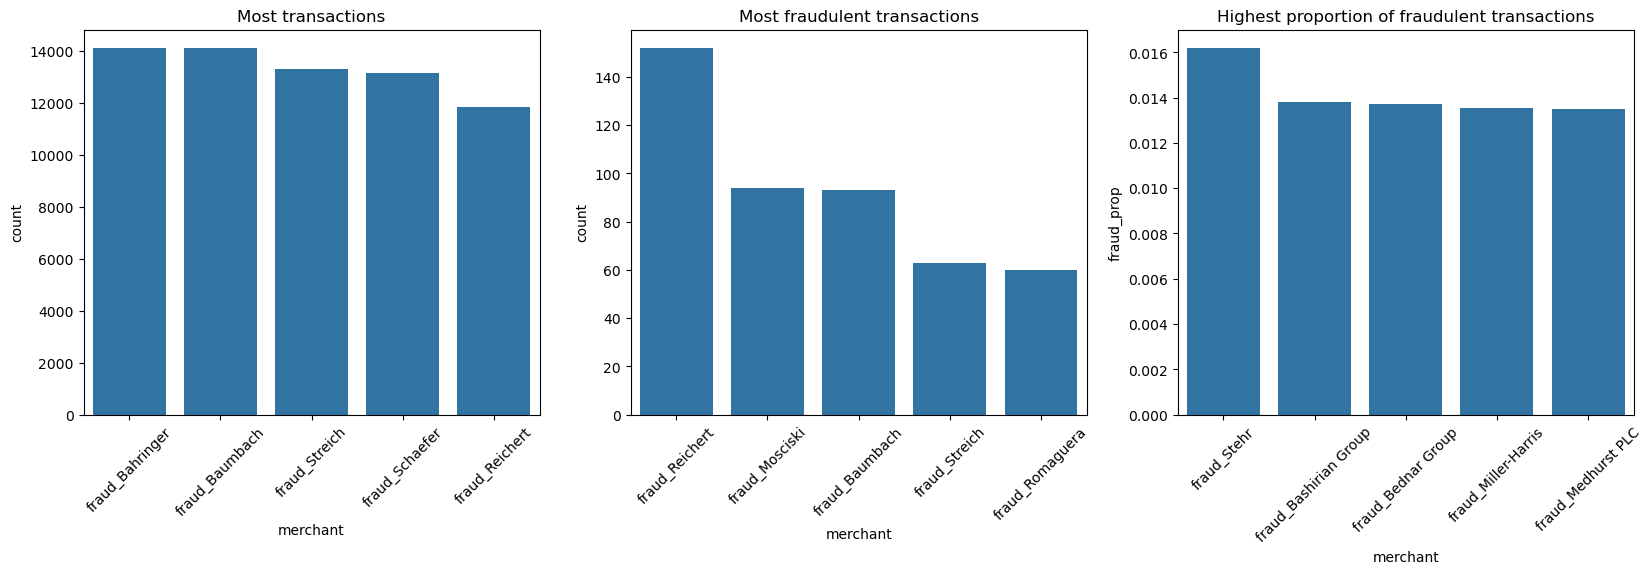

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), gridspec_kw={'width_ratios': [1, 1, 1]})
top_merchants = df['merchant'].value_counts().head().reset_index()
sns.barplot(data = top_merchants, x = 'merchant', y = 'count', ax = axes[0])
axes[0].set_title('Most transactions')
axes[0].tick_params(axis='x', rotation=45)

top_merchants_fraud = fraud_trans_df['merchant'].value_counts().head().reset_index()
sns.barplot(data = top_merchants_fraud, x = 'merchant', y = 'count', ax = axes[1])
axes[1].set_title('Most fraudulent transactions')
axes[1].tick_params(axis='x', rotation=45)

top_merchants_full = df['merchant'].value_counts().reset_index()
top_merchants_fraud_full = fraud_trans_df['merchant'].value_counts().reset_index()
merchants_trans = pd.merge(top_merchants_full, top_merchants_fraud_full, how = 'left', on = 'merchant', suffixes = ['_all', '_fraud']).dropna()
merchants_trans['fraud_prop'] = merchants_trans['count_fraud'] / merchants_trans['count_all']
sns.barplot(data = merchants_trans.sort_values('fraud_prop', ascending = False).head(), x = 'merchant', y = 'fraud_prop', ax = axes[2])
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_title('Highest proportion of fraudulent transactions')


Text(0.5, 1.0, 'Number of states that merchants operate in')

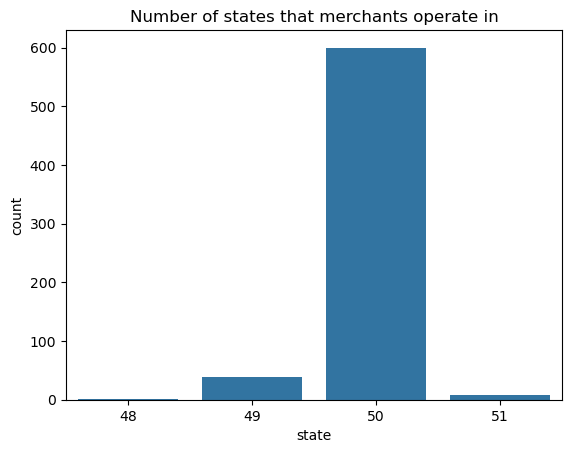

In [39]:
merchant_state = df.groupby('merchant').nunique()['state'].reset_index()
state_count = merchant_state['state'].value_counts().reset_index()
sns.barplot(data = state_count, x = 'state', y = 'count')
plt.title('Number of states that merchants operate in')

### Customer

Almost all the customers in the dataset have been involved in fraud

In [42]:
print(f"There are {len(df['cc_num'].unique())} unique customers")
print(f"There are {len(fraud_trans_df['cc_num'].unique())} unique customers involved in fraud")

There are 997 unique customers
There are 985 unique customers involved in fraud


#### Age

Text(0.5, 1.0, 'Number of fraudulent transactions per age group')

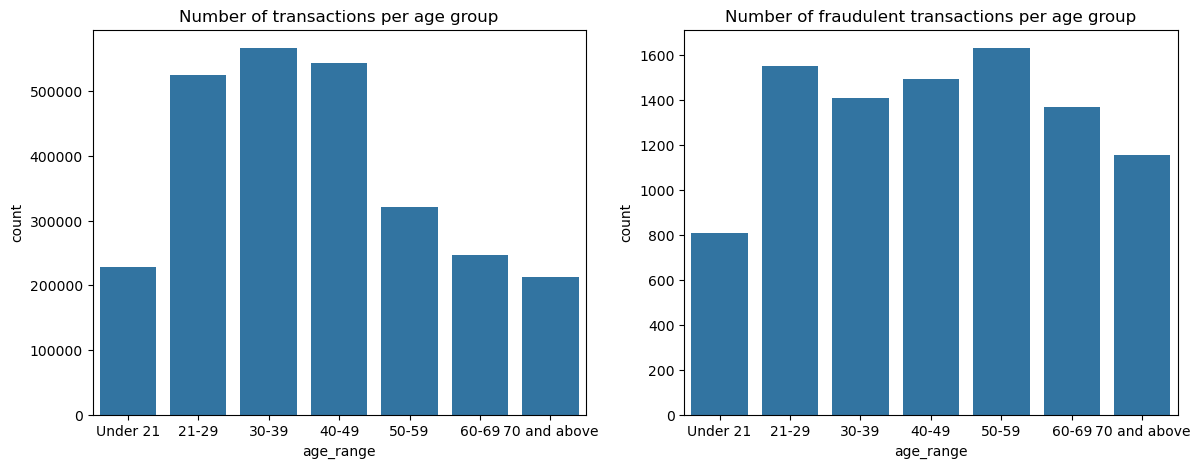

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})
sns.countplot(data = df, x = 'age_range', order = ['Under 21', '21-29', '30-39', '40-49', '50-59', '60-69', '70 and above'], ax = axes[0])
axes[0].set_title('Number of transactions per age group')

sns.countplot(data = fraud_trans_df, x = 'age_range', order = ['Under 21', '21-29', '30-39', '40-49', '50-59', '60-69', '70 and above'], ax = axes[1])
axes[1].set_title('Number of fraudulent transactions per age group')

#### Gender

Text(0.5, 1.0, 'Gender split of fraudulent transactions')

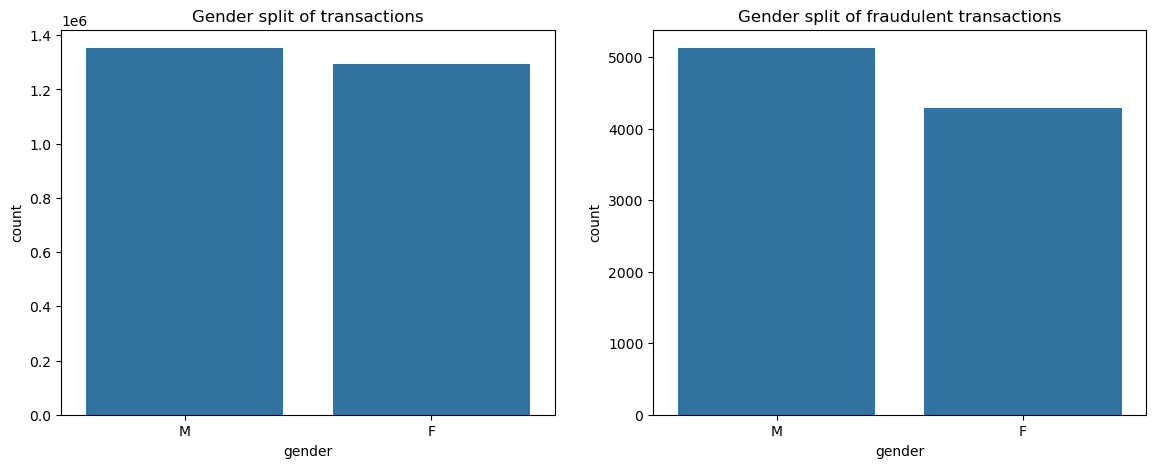

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})
sns.barplot(data = df['gender'].value_counts().reset_index(), x = 'gender', y = 'count', ax = axes[0])
axes[0].set_title('Gender split of transactions')

sns.barplot(data = fraud_trans_df['gender'].value_counts().reset_index(), x = 'gender', y = 'count', ax = axes[1])
axes[1].set_title('Gender split of fraudulent transactions')


#### Occupation

Text(0.5, 1.0, 'Jobs with highest number of fraudulent transactions')

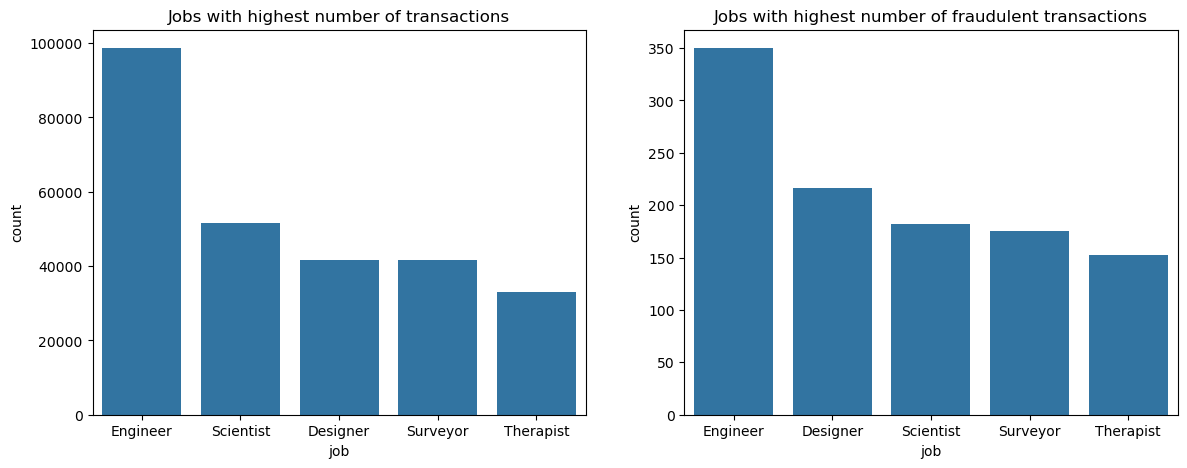

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})
top_jobs = df['job'].value_counts().head().reset_index()
sns.barplot(data = top_jobs, x = 'job', y = 'count', ax = axes[0])
axes[0].set_title('Jobs with highest number of transactions')

top_jobs_fraud = fraud_trans_df['job'].value_counts().head().reset_index()
sns.barplot(data = top_jobs_fraud, x = 'job', y = 'count', ax = axes[1])
axes[1].set_title('Jobs with highest number of fraudulent transactions')


### Network? (sample is 13 May 2021 in LA)

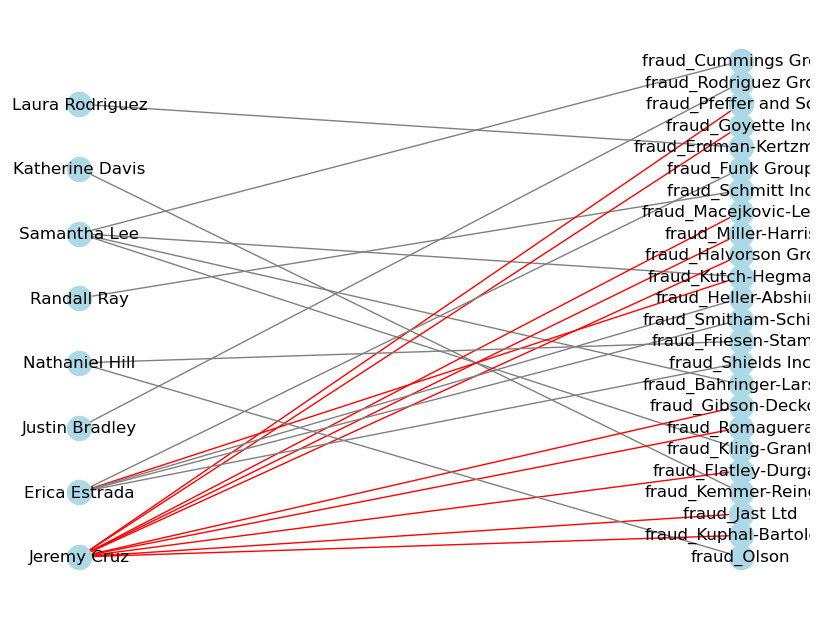

In [57]:
plt.figure(figsize = (8, 6))

customers = df.loc[(df['city'] == 'Los Angeles, CA') & (df['trans_date'] == '2021-05-13'), 'name'].unique()
merchants = df.loc[(df['city'] == 'Los Angeles, CA') & (df['trans_date'] == '2021-05-13'), 'merchant'].unique()

BG = nx.Graph()
BG.add_nodes_from(customers, bipartite = 0)
BG.add_nodes_from(merchants, bipartite = 1)
BG.add_edges_from(df.loc[(df['city'] == 'Los Angeles, CA') & (df['trans_date'] == '2021-05-13')][['name', 'merchant']].itertuples(index=False, name=None))
ec = ['grey' if x == 0 else 'red' for x in df.loc[(df['city'] == 'Los Angeles, CA') & (df['trans_date'] == '2021-05-13'), 'is_fraud']]

left = {n for n, d in BG.nodes(data=True) if d["bipartite"] == 0}  # Customers
right = {n for n, d in BG.nodes(data=True) if d["bipartite"] == 1}
pos = {node: (1, idx * 3) for idx, node in enumerate(left)}  # Customers on the left
pos.update({node: (2, idx) for idx, node in enumerate(right)})  # Merchants on the right

nx.draw(BG, pos=pos, with_labels=True, node_size=300, node_color="lightblue", edge_color=ec)
plt.show()

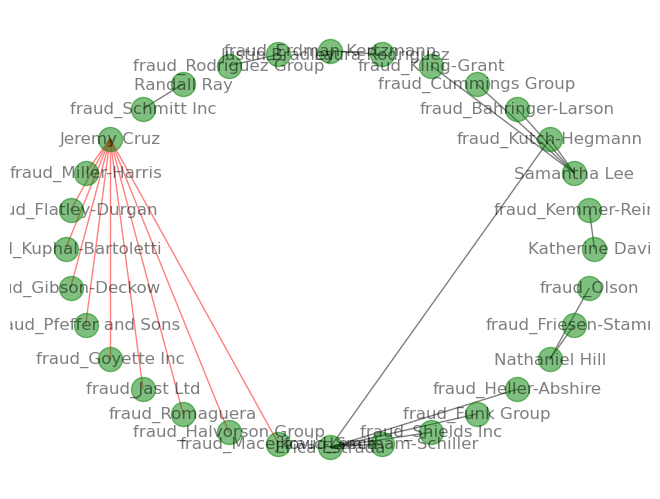

In [58]:
G = nx.Graph()
G = nx.from_pandas_edgelist(df.loc[(df['city'] == 'Los Angeles, CA') & (df['trans_date'] == '2021-05-13')], source='name', target='merchant', edge_attr=['is_fraud'])
edge_colors = ['red' if G[u][v]['is_fraud'] == 1 else 'black' for u, v in G.edges()]
nx.draw_circular(G, with_labels=True, node_size=300, alpha=0.5, node_color='g', edge_color=edge_colors)

### Transactions

#### Time

Text(0.5, 1.0, 'Number of fraudulent transactions by month')

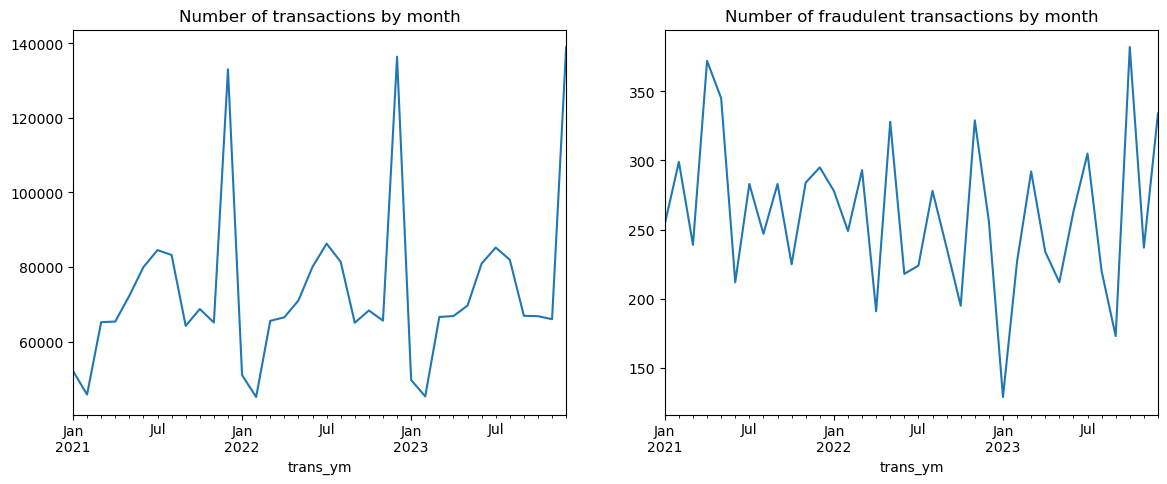

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

by_ym = df['trans_ym'].value_counts().sort_index()
by_ym.plot(ax = axes[0])
axes[0].set_title('Number of transactions by month')

by_ym_fraud = fraud_trans_df['trans_ym'].value_counts().sort_index()
by_ym_fraud.plot(ax = axes[1])
axes[1].set_title('Number of fraudulent transactions by month')

Text(0.5, 1.0, 'Most common time to commit fraud')

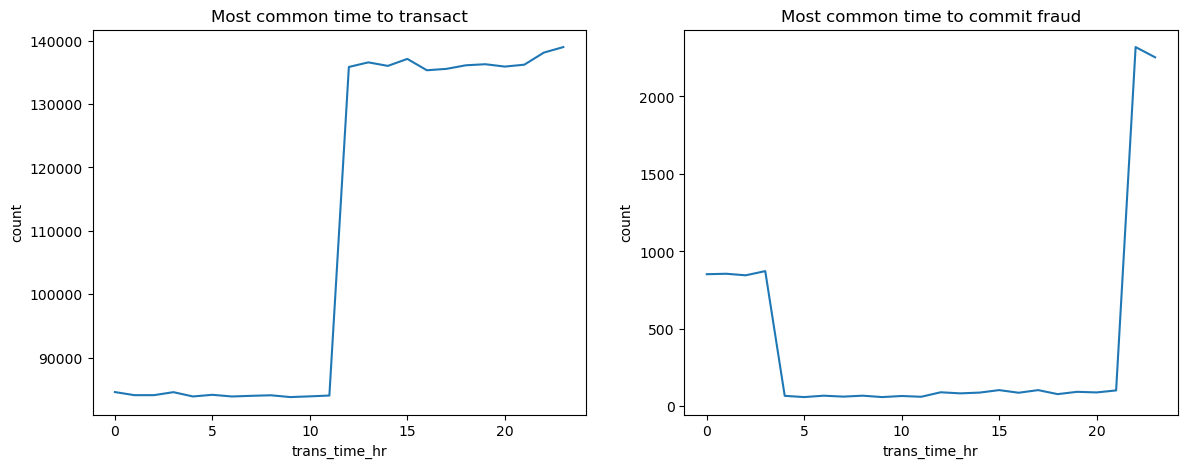

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [1, 1]})

popular_time = df['trans_time_hr'] .value_counts().reset_index()
sns.lineplot(data = popular_time, x = 'trans_time_hr', y = 'count', ax = axes[0])
axes[0].set_title('Most common time to transact')

popular_time_fraud = fraud_trans_df['trans_time_hr'].value_counts().reset_index()
sns.lineplot(data = popular_time_fraud, x = 'trans_time_hr', y = 'count', ax = axes[1])
axes[1].set_title('Most common time to commit fraud')

Text(0.5, 1.0, 'Fraudulent transactions per category')

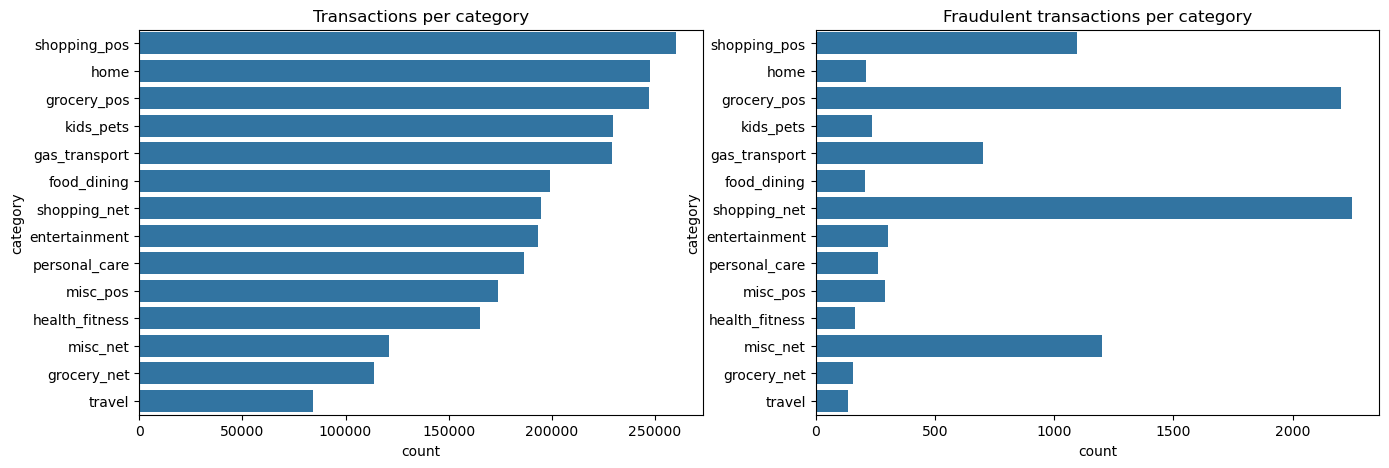

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [1, 1]})

top_categories = df['category'].value_counts().reset_index()
sns.barplot(data = top_categories, y = 'category', x = 'count', ax = axes[0])
axes[0].set_title('Transactions per category')

top_categories_fraud = fraud_trans_df['category'].value_counts().reset_index()
sns.barplot(data = top_categories_fraud, y = 'category', x = 'count', ax = axes[1], order = top_categories['category'])
axes[1].set_title('Fraudulent transactions per category')

#### Geography

Text(0.5, 1.0, 'Number of recorded cities per state')

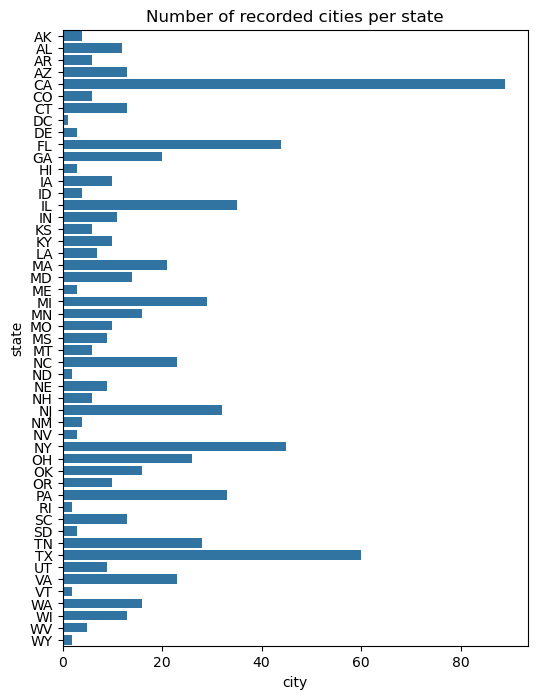

In [50]:
plt.figure(figsize = (6, 8))
n_city = df.groupby('state').nunique()['city'].reset_index()
sns.barplot(data = n_city, y = 'state', x ='city')
plt.title('Number of recorded cities per state')